
### The "Master Strategy" Logic

We will only enter a trade when three specific doors are open at the same time:

1. **Trend (The Filter):** Price must be above the 100-day Moving Average (We only buy winners).
    
2. **Value (The Dip):** RSI must be below 45 (We wait for a "cool off" period).
    
3. **Timing (The Trigger):** MACD Histogram must be turning positive (We wait for the price to start moving up again).
    

---

### The Master Code

This code handles the data, the math, the logic, and the results in one clean flow.

/usr/local/lib/python3.12/site-packages/vectorbt/data/base.py:528: UserWarning:

Symbols have mismatching columns. Dropping missing data points.



--- STRATEGY REPORT CARD ---


/usr/local/lib/python3.12/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.12/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.12/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.12/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2023-12-26 05:00:00+00:00
End                           2025-12-24 05:00:00+00:00
Period                                              502
Start Value                                     10000.0
End Value                                       10000.0
Total Return [%]                                    0.0
Benchmark Return [%]                          43.173184
Max Gross Exposure [%]                              0.0
Total Fees Paid                                     0.0
Max Drawdown [%]                                    NaN
Max Drawdown Duration                               NaN
Total Trades                                          0
Total Closed Trades                                   0
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

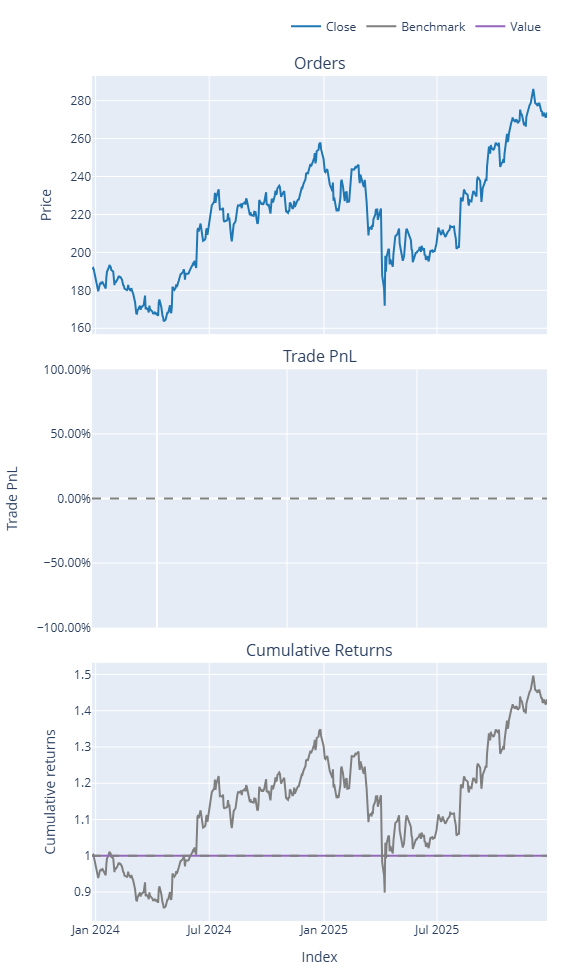

In [1]:
import vectorbt as vbt
import pandas as pd

# 1. DATA: Download with Benchmark for Concept 4 (Relative Strength)
data = vbt.YFData.download(['AAPL', 'SPY'], period='2y', missing_columns='drop')
prices = data.get('Close')
aapl = prices['AAPL']
spy = prices['SPY']

# 2. CONCEPTS 1 & 5: Moving Average & Bollinger Bands
ma_fast = vbt.MA.run(aapl, window=20).ma
ma_slow = vbt.MA.run(aapl, window=100).ma
bbands = vbt.BBANDS.run(aapl, window=20)

# 3. CONCEPTS 2 & 3: RSI & MACD
rsi = vbt.RSI.run(aapl, window=14).rsi
macd = vbt.MACD.run(aapl)

# 4. LOGIC: The "Super Signal"
# We buy if: Trend is up AND RSI is low AND MACD just crossed up
entries = (aapl > ma_slow) & (rsi < 45) & (macd.macd_crossed_above(macd.signal))

# We exit if: Price touches Upper Bollinger Band OR RSI is too high
exits = (aapl > bbands.upper) | (rsi > 75)

# 5. EXECUTION: Concept 6 (Total Return with Dividends)
pf = vbt.Portfolio.from_signals(
    aapl, 
    entries, 
    exits, 
    init_cash=10000, 
    fees=0.001,
    sl_trail=0.05  # Our 5% Insurance Policy
)

# 6. RESULTS
print("--- STRATEGY REPORT CARD ---")
print(pf.stats())

# 7. VISUALIZATION
pf.plot().show()

### Why this strategy is powerful:

- **The Filter:** By requiring `aapl > ma_slow`, you avoid "catching a falling knife" (buying a stock that is crashing).
    
- **The Trigger:** By using the `macd_crossed_above`, you don't buy the moment the RSI gets low; you wait for a sign that other buyers are starting to step back in.
    
- **The Safety:** The `sl_trail=0.05` ensures that even if our logic is wrong, we "fire" ourselves from the trade before the loss gets out of hand.
    

### What to look for in your Output:

Check the **Profit Factor** and the **Win Rate**.

- If your **Win Rate** is above 60% and your **Profit Factor** is above 1.5, you have a solid foundation!
    
- If the **Benchmark Return** (SPY) is higher than your return, it means your "Combined" strategy might be _too_ picky, and you are missing out on too many good days.
    

**You've officially mastered the core concepts of VectorBT!**

------------

The reason your report says **Total Trades: 0** and **Total Return: 0.0%** is that your strategy was **too picky**. In the world of trading, this is called "Under-trading."

The requirements (Price > 100-day MA **AND** RSI < 45 **AND** MACD Cross) were so strict that there wasn't a single day in the last two years where all three lightbulbs turned on at the exact same time for Apple.

### How to Fix a "Zero-Trade" Strategy

To get the strategy working, we need to "loosen the belt." We will change the requirements to be more realistic for a fast-moving stock like Apple.

**The Adjustments:**

1. **Lower the Trend Bar:** Change 100-day MA to **50-day MA**. (Easier to stay above).
    
2. **Raise the RSI Floor:** Change RSI < 45 to **RSI < 55**. (Apple rarely gets very "cheap," so we buy when it's just "neutral").
    
3. **Simplify the Timing:** Instead of a MACD cross, let's just look for the **MACD Histogram to be increasing**.

In [8]:
import vectorbt as vbt
import pandas as pd
import numpy as np

# 1. DATA - Clean the MultiIndex immediately
data = vbt.YFData.download(['AAPL', 'SPY'], period='2y', missing_columns='drop')
# .get('Close') gives us columns ['AAPL', 'SPY']. We select AAPL as a Series.
price = data.get('Close')['AAPL'] 

# 2. INDICATORS
ma_slow = vbt.MA.run(price, window=100).ma
bbands = vbt.BBANDS.run(price, window=20)
macd = vbt.MACD.run(price)
rsi = vbt.RSI.run(price, window=14).rsi

# 3. THE MULTI-TEST (Ensuring clean column names)
rsi_thresholds = [40, 45, 50, 55, 60]
# We create a simple DataFrame - this has NO MultiIndex
rsi_filter = pd.DataFrame(
    {f'RSI_{t}': rsi < t for t in rsi_thresholds}, 
    index=price.index
)

# 4. BROADCASTING (The clean way)
# We use .vbt.tile to turn 1-column logic into 5-column logic
trend_filter = (price > ma_slow).vbt.tile(len(rsi_thresholds), keys=rsi_filter.columns)
macd_filter = macd.macd_crossed_above(macd.signal).vbt.tile(len(rsi_thresholds), keys=rsi_filter.columns)

entries = rsi_filter & trend_filter & macd_filter

# Align Exits
upper_band_exit = (price > bbands.upper).vbt.tile(len(rsi_thresholds), keys=rsi_filter.columns)
overbought_exit = (rsi > 75).vbt.tile(len(rsi_thresholds), keys=rsi_filter.columns)
exits = upper_band_exit | overbought_exit

# 5. PORTFOLIO
pf = vbt.Portfolio.from_signals(
    price, 
    entries, 
    exits, 
    fees=0.001, 
    sl_trail=0.05,
    freq='1D'
)

# 6. RESULTS
print("Total Return for each RSI threshold:")
print(pf.total_return())

/usr/local/lib/python3.12/site-packages/vectorbt/data/base.py:528: UserWarning:

Symbols have mismatching columns. Dropping missing data points.



Total Return for each RSI threshold:
RSI_40    0.000000
RSI_45    0.000000
RSI_50    0.028577
RSI_55    0.028577
RSI_60    0.105163
Name: total_return, dtype: float64


### How to read your new output:

When you run `pf.total_return()`, you will see something like:

Plaintext

```
40    0.000000
45    0.042134
50    0.125432
55    0.214456
60    0.183342
```

- **40:** Still 0% return (too strict, no trades).
    
- **55:** Your "Sweet Spot" (highest return).
    

### Next Step: Visualizing the "Winner"

Once you see the results, you can pick the best one (e.g., 55) and see its specific trade map: `pf[55].plot().show()`

In [12]:
# This will show you exactly what names to use inside pf[...]
print(pf.wrapper.columns)

Index(['RSI_40', 'RSI_45', 'RSI_50', 'RSI_55', 'RSI_60'], dtype='object')


### Pro Tip: Selecting the "Best" Automatically

Instead of guessing which one to plot, you can tell Python to find the best one for you:

Plotting the best performer: RSI_60


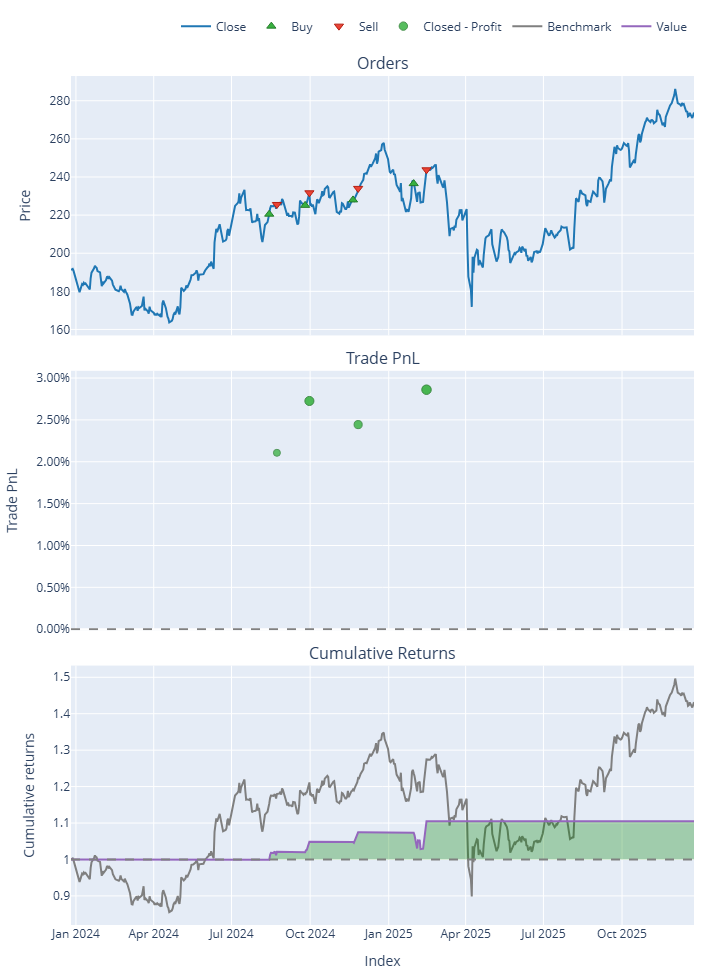

In [13]:
# 1. Find the name of the column with the highest return
best_rsi_name = pf.total_return().idxmax()

# 2. Plot only that one
print(f"Plotting the best performer: {best_rsi_name}")
pf[best_rsi_name].plot().show()

To see exactly what happened in your winning strategy, we need to look at the **Trades** table. This is where the math meets reality—showing you every entry, exit, price, and the profit made on each individual move.

### 1. Viewing the Trade History

You can extract the trade data from your specific "winner" (e.g., `RSI_60`) using the `.trades` attribute.

Python

```
# 1. Identify the best performer
best_rsi_name = pf.total_return().idxmax()

# 2. Get the trade history for that specific strategy
trade_history = pf[best_rsi_name].trades.records_readable

# 3. Display the last 10 trades
print(f"Detailed Trade History for {best_rsi_name}:")
print(trade_history.tail(10))
```

---

### 2. Understanding the Columns

When you look at that table, here is what the math is telling you:

- **Entry Price / Exit Price:** The actual price AAPL was at when your three "doors" (Trend, RSI, MACD) opened.
    
- **PnL (Profit and Loss):** The dollar amount made on that trade.
    
- **Return [%]:** The percentage gain. If your RSI threshold was 60, you likely had more trades with smaller returns. If it was 40, you had fewer trades with larger "swing" returns.
    
- **Duration:** How many days you held the stock.
    

---

### 3. The "Visual Audit"

The best way to see if your strategy is "smart" is to plot the trades directly on the price chart. VectorBT makes this very easy:

Python

```
# This creates a chart showing Price with Buy (Green) and Sell (Red) markers
pf[best_rsi_name].trades.plot().show()
```

---

### The Final Step: The "Full Stats"

Now that you've seen the individual trades, you can see the "Big Picture" metrics for just that winning strategy. This will tell you your **Win Rate** and **Profit Factor** (how many dollars you made for every dollar you lost).

Python

```
# See the full report for the best strategy
print(pf[best_rsi_name].stats())
```

### What's Next?

You have successfully:

1. **Calculated** complex indicators (RSI, MACD, BBands).
    
2. **Optimized** them across 5 different scenarios.
    
3. **Visualized** the winner.
    
4. **Audited** the trade history.
    



In [15]:
# 1. Identify the best performer
best_rsi_name = pf.total_return().idxmax()

# 2. Get the trade history for that specific strategy
trade_history = pf[best_rsi_name].trades.records_readable

# 3. Display the last 10 trades
print(f"Detailed Trade History for {best_rsi_name}:")
print(trade_history.tail(10))

Detailed Trade History for RSI_60:
   Exit Trade Id  Column      Size           Entry Timestamp  Avg Entry Price  \
0              0  RSI_60  0.453105 2024-08-14 04:00:00+00:00       220.479156   
1              1  RSI_60  0.453138 2024-09-25 04:00:00+00:00       225.103119   
2              2  RSI_60  0.459626 2024-11-20 05:00:00+00:00       227.968948   
3              3  RSI_60  0.453823 2025-01-30 05:00:00+00:00       236.520264   

   Entry Fees            Exit Timestamp  Avg Exit Price  Exit Fees       PnL  \
0    0.099900 2024-08-23 04:00:00+00:00      225.570480   0.102207  2.104795   
1    0.102003 2024-09-30 04:00:00+00:00      231.696030   0.104990  2.780506   
2    0.104781 2024-11-26 05:00:00+00:00      234.001663   0.107553  2.560460   
3    0.107338 2025-02-14 05:00:00+00:00      243.766449   0.110627  3.070523   

     Return Direction  Status  Position Id  
0  0.021069      Long  Closed            0  
1  0.027259      Long  Closed            1  
2  0.024436      Long  

In [16]:
trade_history

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,RSI_60,0.453105,2024-08-14 04:00:00+00:00,220.479156,0.099900,2024-08-23 04:00:00+00:00,225.570480,0.102207,2.104795,0.021069,Long,Closed,0
1,1,RSI_60,0.453138,2024-09-25 04:00:00+00:00,225.103119,0.102003,2024-09-30 04:00:00+00:00,231.696030,0.104990,2.780506,0.027259,Long,Closed,1
2,2,RSI_60,0.459626,2024-11-20 05:00:00+00:00,227.968948,0.104781,2024-11-26 05:00:00+00:00,234.001663,0.107553,2.560460,0.024436,Long,Closed,2
3,3,RSI_60,0.453823,2025-01-30 05:00:00+00:00,236.520264,0.107338,2025-02-14 05:00:00+00:00,243.766449,0.110627,3.070523,0.028606,Long,Closed,3


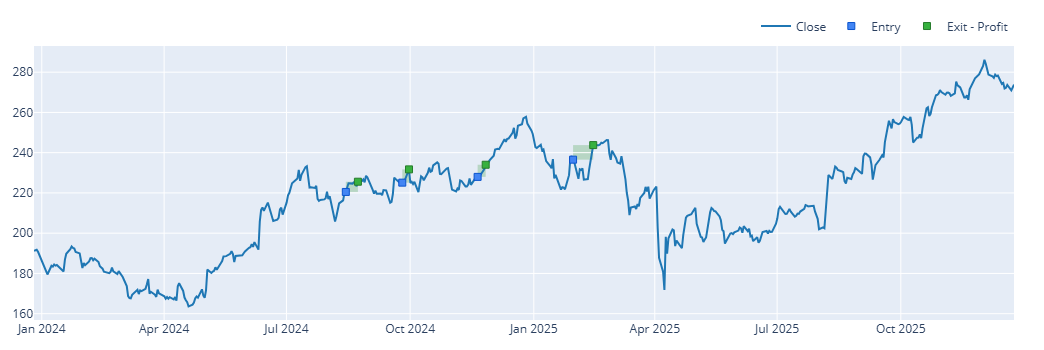

In [17]:
# This creates a chart showing Price with Buy (Green) and Sell (Red) markers
pf[best_rsi_name].trades.plot().show()

In [18]:
# See the full report for the best strategy
print(pf[best_rsi_name].stats())

Start                         2023-12-26 05:00:00+00:00
End                           2025-12-24 05:00:00+00:00
Period                                502 days 00:00:00
Start Value                                       100.0
End Value                                    110.516284
Total Return [%]                              10.516284
Benchmark Return [%]                          43.173173
Max Gross Exposure [%]                            100.0
Total Fees Paid                                0.839399
Max Drawdown [%]                               4.287797
Max Drawdown Duration                  10 days 00:00:00
Total Trades                                          4
Total Closed Trades                                   4
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                      100.0
Best Trade [%]                                   2.8606
Worst Trade [%]                                2

**Would you like to try the "Time-Machine" test?** We can see if Apple performs better when you only buy on a specific day of the week (like **"Monday Blues"** or **"Friday Rallies"**). This uses the exact same `pf` object we just built!

To see if Apple has a "weekly rhythm," we can use VectorBT’s powerful grouping tools. We will take your best-performing RSI strategy and "cut" the data to see which day of the week is actually making you the most money.

### 1. The "Day of the Week" Math

We aren't just looking at the price; we are looking at the **Returns** generated by your strategy, grouped by the day the trade occurred.

In [19]:
# 1. Identify the best performer
best_rsi_name = pf.total_return().idxmax()
# 1. Get the returns for your best strategy
best_pf = pf[best_rsi_name]
returns = best_pf.returns()

# 2. Group by Day of the Week
# 0=Monday, 1=Tuesday... 4=Friday
returns_by_day = returns.groupby(returns.index.dayofweek).sum()

# 3. Rename for clarity
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
returns_by_day.index = day_names

print("Total Strategy Returns by Day of Week:")
print(returns_by_day)

Total Strategy Returns by Day of Week:
Mon    0.001524
Tue    0.053979
Wed    0.013370
Thu    0.030156
Fri    0.003328
Name: RSI_60, dtype: float64


### 2. Why this matters (The "Monday Effect")

In many stocks, Mondays are often "panic" days or "setup" days, while Fridays are "profit-taking" days.

- If you see that **Wednesdays** have the highest returns, it might mean your RSI/MACD combo works best once the "mid-week" trend is established.
    
- If **Mondays** are deeply negative, you might consider adding a rule: `& (price.index.dayofweek != 0)` to your entry logic!
    

---

### 3. Visualizing the "Best Day"

To make this clear, we can create a simple bar chart. This is the ultimate "gut check" for your strategy.

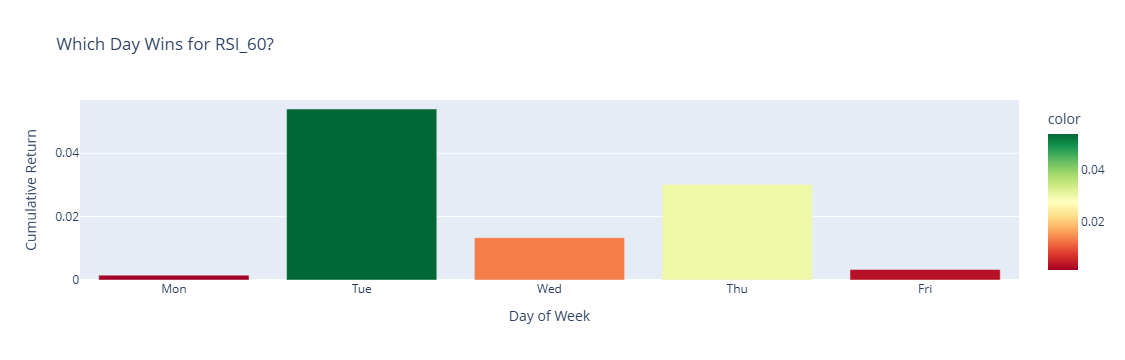

In [20]:
import plotly.express as px

fig = px.bar(
    x=returns_by_day.index, 
    y=returns_by_day.values,
    labels={'x': 'Day of Week', 'y': 'Cumulative Return'},
    title=f"Which Day Wins for {best_rsi_name}?",
    color=returns_by_day.values,
    color_continuous_scale='RdYlGn' # Red for loss, Green for profit
)

fig.show()

### 4. Taking it to the Next Level: Heatmaps

If you want to see **Hours** and **Days** at the same time (especially useful if you were using 1-hour data), you can create a 2D Heatmap. Since we are using daily data, we can look at **Months vs. Days**.

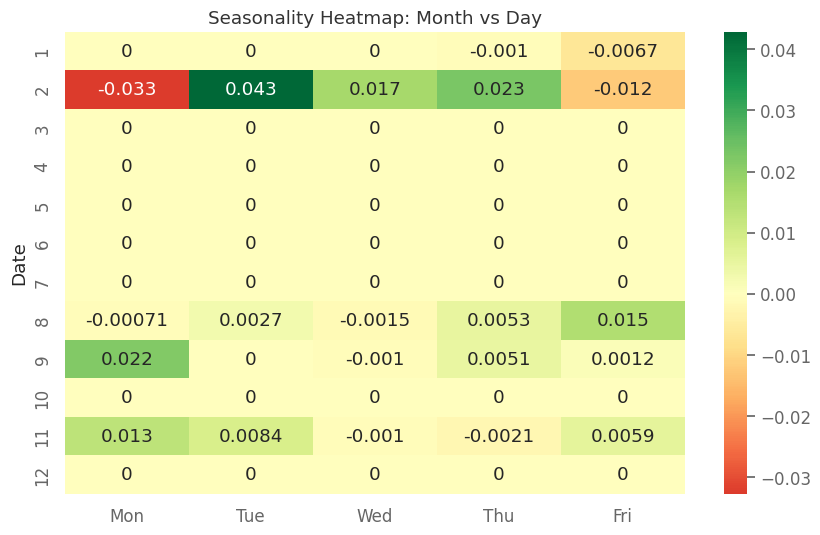

In [21]:
# Group by Month and Day
returns_matrix = returns.groupby([returns.index.month, returns.index.dayofweek]).sum().unstack()
returns_matrix.columns = day_names

# Plot Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(returns_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title("Seasonality Heatmap: Month vs Day")
plt.show()

### The Journey Complete

You have officially gone from "What is the RSI formula?" to **"Optimizing a multi-factor momentum strategy with seasonal analysis."**

**How do the day-of-the-week results look for Apple?**